In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [102]:
df = pd.read_csv("bank-full.csv", delimiter = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [103]:
df.y.value_counts() # target variable is skewed towards false; will alter with ML performance

,count
y,
no,39922
yes,5289


In [104]:
df.info()
print("\n")
print(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age            77
job            12
marital         3
education       4
default         2
balance

In [105]:
df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
df['default'] = df['default'].map({"yes": True, "no": False})
df['housing'] = df['housing'].map({"yes": True, "no": False})
df['loan'] = df['loan'].map({"yes": True, "no": False})
df['contact'] = df['contact'].astype('category')
df['month'] = df['month'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')
df['y'] = df['y'].map({"yes": True, "no": False})

In [106]:
df.info()
print('\n')
unique_values_per_column = df.nunique()
print(unique_values_per_column)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  bool    
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  bool    
 7   loan       45211 non-null  bool    
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  y          45211 non-null  bool    
dtypes: bool(4), category(6), int64(7)
memory usage: 2.8 MB


age            77
job            12
marital       

In [107]:
for col in df.columns:
    if col == 'y':
        continue
    elif df[col].dtype == 'category':
        df[col] = df[col].replace('unknown', df[col].mode()[0])
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].fillna(df[col].mean(), inplace=True)

<ipython-input-107-6355ee1b446a>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-107-6355ee1b446a>:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[col] = df[col].replace('unknown', df[col].mode()[0])


In [108]:
# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

In [109]:
print(f"Data before removing outliers: {df.shape}")
# Apply Isolation Forest only on numerical data
from sklearn.ensemble import IsolationForest

iso = IsolationForest()  # Adjust contamination to your data
numerical_data = df[numerical_features]
yhat = iso.fit_predict(numerical_data)  # Apply it to numerical features
mask = yhat != -1  # Create a mask for non-outliers

# Keep only the rows that are not outliers
df = df[mask]
print(f"Data after removing outliers: {df.shape}")

Data before removing outliers: (45211, 17)
Data after removing outliers: (39301, 17)


In [110]:
df.info()
print('\n')
unique_values_per_column = df.nunique()
print(unique_values_per_column)
# nulls are actually strings "unknown"

<class 'pandas.core.frame.DataFrame'>
Index: 39301 entries, 0 to 45209
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        39301 non-null  int64   
 1   job        39301 non-null  category
 2   marital    39301 non-null  category
 3   education  39301 non-null  category
 4   default    39301 non-null  bool    
 5   balance    39301 non-null  int64   
 6   housing    39301 non-null  bool    
 7   loan       39301 non-null  bool    
 8   contact    39301 non-null  category
 9   day        39301 non-null  int64   
 10  month      39301 non-null  category
 11  duration   39301 non-null  int64   
 12  campaign   39301 non-null  int64   
 13  pdays      39301 non-null  int64   
 14  previous   39301 non-null  int64   
 15  poutcome   39301 non-null  category
 16  y          39301 non-null  bool    
dtypes: bool(4), category(6), int64(7)
memory usage: 2.8 MB


age            76
job            11
marital         3
e

In [111]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [112]:
for col in df.columns:
  print(df[col].value_counts())
  print("\n")

age
32    1850
31    1760
33    1760
34    1734
35    1685
      ... 
90       1
92       1
95       1
94       1
89       1
Name: count, Length: 76, dtype: int64


job
blue-collar      8953
management       8114
technician       6651
admin.           4507
services         3725
retired          1676
self-employed    1373
entrepreneur     1312
unemployed       1145
housemaid        1107
student           738
Name: count, dtype: int64


marital
married     23723
single      11039
divorced     4539
Name: count, dtype: int64


education
secondary    21972
tertiary     11327
primary       6002
Name: count, dtype: int64


default
False    38552
True       749
Name: count, dtype: int64


balance
 0       3210
 1        180
 2        138
 4        127
 3        121
         ... 
 9068       1
-577        1
-985        1
 8873       1
 7038       1
Name: count, Length: 6376, dtype: int64


housing
True     21887
False    17414
Name: count, dtype: int64


loan
False    32819
True      6482
Name:

In [113]:
df = df.drop('poutcome', axis=1) # more than 50% of data is null
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,False,2143,True,False,cellular,5,may,261,1,-1,0,False
1,44,technician,single,secondary,False,29,True,False,cellular,5,may,151,1,-1,0,False
2,33,entrepreneur,married,secondary,False,2,True,True,cellular,5,may,76,1,-1,0,False
3,47,blue-collar,married,secondary,False,1506,True,False,cellular,5,may,92,1,-1,0,False
4,33,blue-collar,single,secondary,False,1,False,False,cellular,5,may,198,1,-1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,False,113,False,False,cellular,17,nov,266,1,-1,0,True
45205,25,technician,single,secondary,False,505,False,True,cellular,17,nov,386,2,-1,0,True
45206,51,technician,married,tertiary,False,825,False,False,cellular,17,nov,977,3,-1,0,True
45207,71,retired,divorced,primary,False,1729,False,False,cellular,17,nov,456,2,-1,0,True


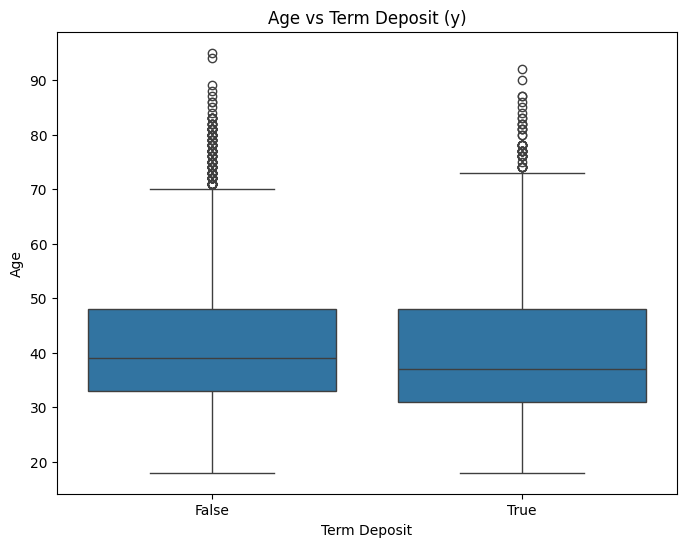

In [114]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=df)
plt.title('Age vs Term Deposit (y)')
plt.xlabel('Term Deposit')
plt.ylabel('Age')
plt.show()

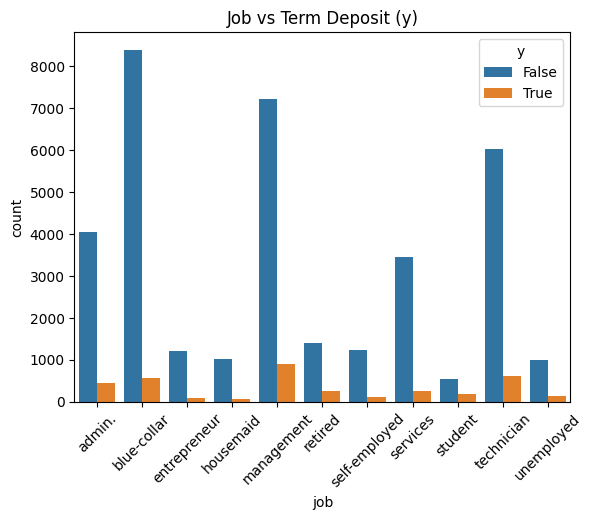

In [115]:
sns.countplot(x='job', hue='y', data=df)
plt.title('Job vs Term Deposit (y)')
plt.xticks(rotation=45)
plt.show()

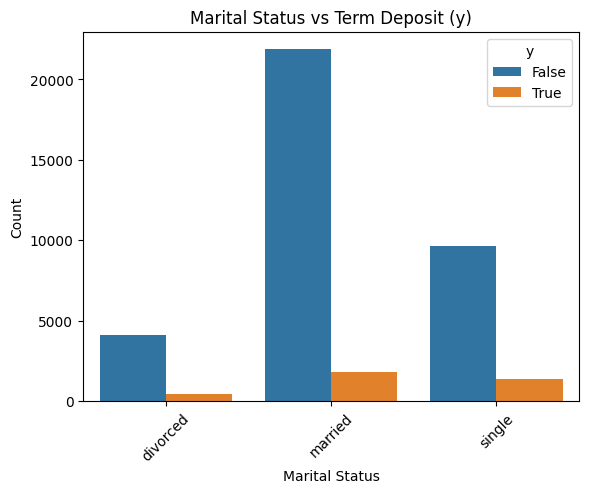

In [116]:
sns.countplot(x='marital', hue='y', data=df)
plt.title('Marital Status vs Term Deposit (y)')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

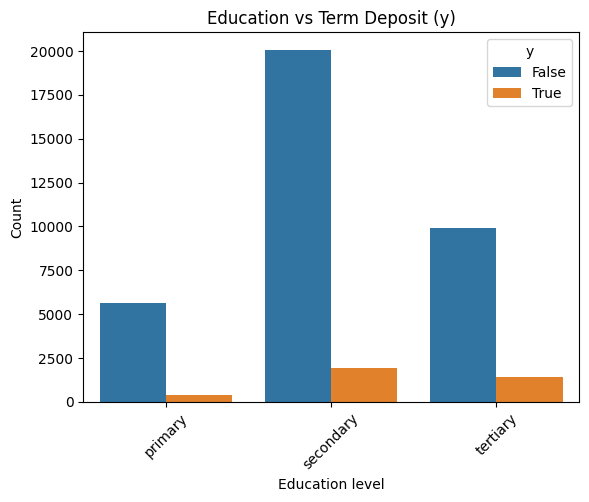

In [117]:
sns.countplot(x='education', hue='y', data=df)
plt.title("Education vs Term Deposit (y)")
plt.xlabel("Education level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

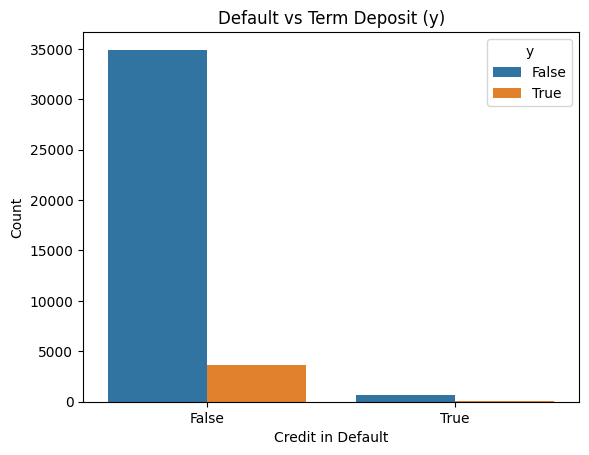

In [118]:
sns.countplot(x='default', hue='y', data=df)
plt.title('Default vs Term Deposit (y)')
plt.xlabel('Credit in Default')
plt.ylabel('Count')
plt.show()

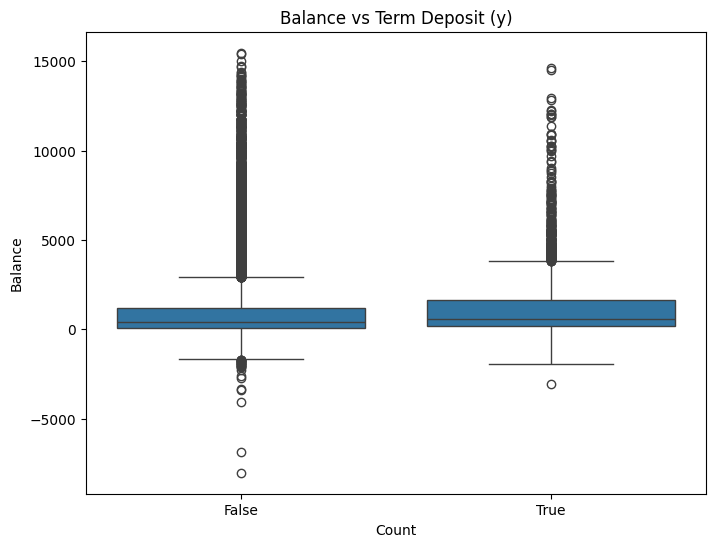

In [119]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='balance', data=df)
plt.title('Balance vs Term Deposit (y)')
plt.xlabel('Count')
plt.ylabel('Balance')
plt.show()

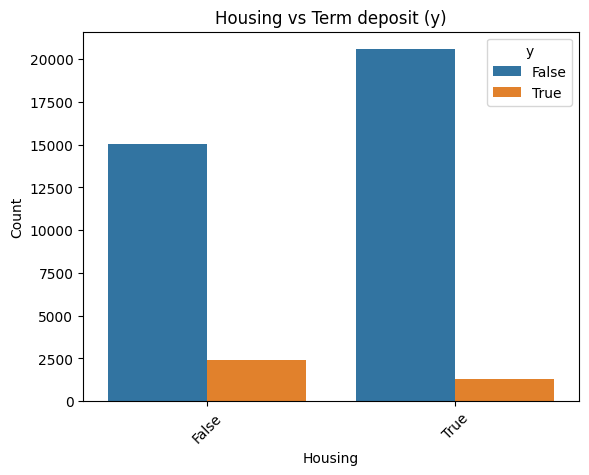

In [120]:
sns.countplot(x='housing', hue='y', data=df)
plt.title("Housing vs Term deposit (y)")
plt.xlabel("Housing")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

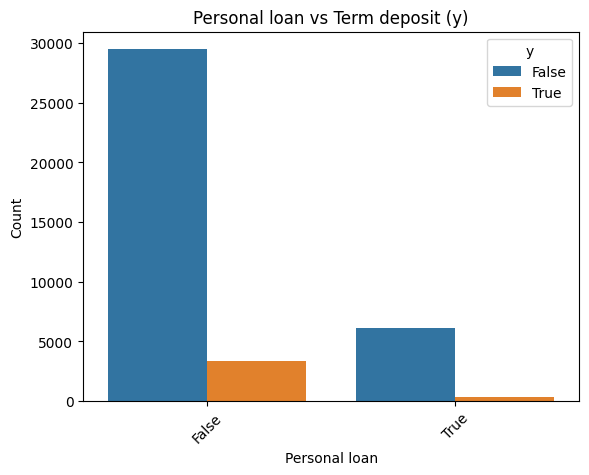

In [121]:
sns.countplot(x='loan', hue='y', data=df)
plt.title("Personal loan vs Term deposit (y)")
plt.xlabel("Personal loan")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

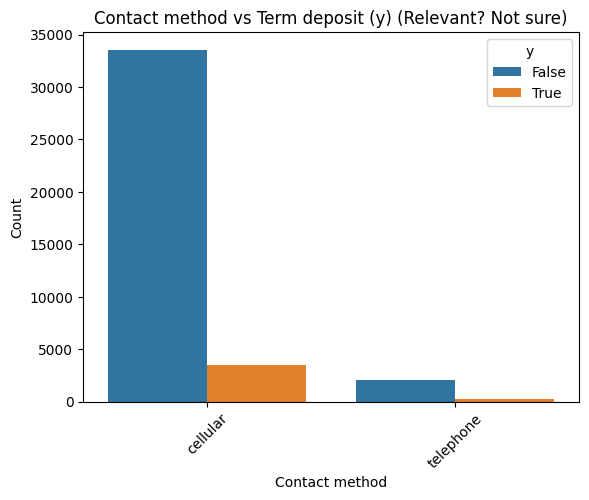

In [122]:
sns.countplot(x='contact', hue='y', data=df)
plt.title("Contact method vs Term deposit (y) (Relevant? Not sure)")
plt.xlabel("Contact method")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

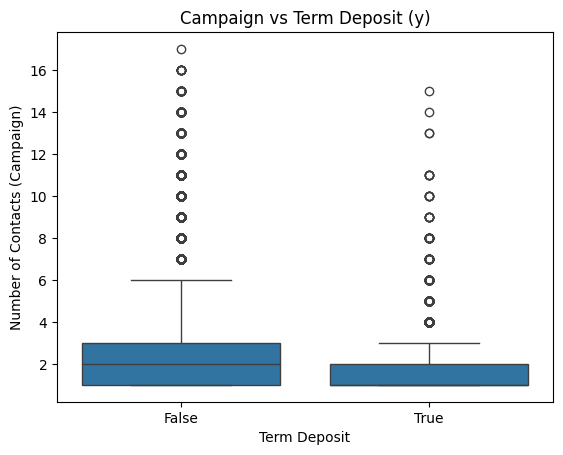

In [123]:
sns.boxplot(x='y', y='campaign', data=df)
plt.title('Campaign vs Term Deposit (y)')
plt.xlabel('Term Deposit')
plt.ylabel('Number of Contacts (Campaign)')
plt.show()

In [124]:
job_categories = {
    'management': 'white_collar', 'technician': 'blue_collar', 'entrepreneur': 'self_employed',
    'blue-collar': 'blue_collar', 'admin.': 'white_collar', 'services': 'services',
    'retired': 'not_working', 'self-employed': 'self_employed', 'unemployed': 'not_working',
    'housemaid': 'blue_collar', 'student': 'not_working'
}
df['job_category'] = df['job'].map(job_categories)
df['job_category'] = df['job_category'].astype('category')
print("Binned job into job_category successfully.")

Binned job into job_category successfully.


In [125]:
df['income_level'] = pd.cut(df['balance'], bins=[-float('inf'), 0, 1000, 5000, float('inf')], labels=['negative', 'low', 'medium', 'high'])
print("Binned balance into income_level successfully.")

Binned balance into income_level successfully.


In [126]:
df['call_duration_category'] = pd.cut(df['duration'], bins=[0, 100, 300, float('inf')], labels=['short', 'medium', 'long'])
print("Binned duration into call_duration_category successfully.")

Binned duration into call_duration_category successfully.


In [127]:
df['month_numeric'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}).astype(int)
print("Binned month into month_numeric successfully. (To better understand seasonal trends).")

Binned month into month_numeric successfully. (To better understand seasonal trends).


In [128]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,job_category,income_level,call_duration_category,month_numeric
0,58,management,married,tertiary,False,2143,True,False,cellular,5,may,261,1,-1,0,False,white_collar,medium,medium,5
1,44,technician,single,secondary,False,29,True,False,cellular,5,may,151,1,-1,0,False,blue_collar,low,medium,5
2,33,entrepreneur,married,secondary,False,2,True,True,cellular,5,may,76,1,-1,0,False,self_employed,low,short,5
3,47,blue-collar,married,secondary,False,1506,True,False,cellular,5,may,92,1,-1,0,False,blue_collar,medium,short,5
4,33,blue-collar,single,secondary,False,1,False,False,cellular,5,may,198,1,-1,0,False,blue_collar,low,medium,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,23,student,single,tertiary,False,113,False,False,cellular,17,nov,266,1,-1,0,True,not_working,low,medium,11
45205,25,technician,single,secondary,False,505,False,True,cellular,17,nov,386,2,-1,0,True,blue_collar,low,long,11
45206,51,technician,married,tertiary,False,825,False,False,cellular,17,nov,977,3,-1,0,True,blue_collar,low,long,11
45207,71,retired,divorced,primary,False,1729,False,False,cellular,17,nov,456,2,-1,0,True,not_working,medium,long,11


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39301 entries, 0 to 45209
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     39301 non-null  int64   
 1   job                     39301 non-null  category
 2   marital                 39301 non-null  category
 3   education               39301 non-null  category
 4   default                 39301 non-null  bool    
 5   balance                 39301 non-null  int64   
 6   housing                 39301 non-null  bool    
 7   loan                    39301 non-null  bool    
 8   contact                 39301 non-null  category
 9   day                     39301 non-null  int64   
 10  month                   39301 non-null  category
 11  duration                39301 non-null  int64   
 12  campaign                39301 non-null  int64   
 13  pdays                   39301 non-null  int64   
 14  previous                393

In [130]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [131]:
# Initialize empty lists for numerical and categorical features
numerical_features = []
categorical_features = []

# Iterate through each column to classify it as numerical or categorical
for col in df.columns:
    if col == 'y':  # Skip target variable
        continue
    # Check the data type and append to the corresponding list
    if df[col].dtype == 'int64':
        numerical_features.append(col)
    elif df[col].dtype in ['object', 'bool', 'category']: # Should be no objects, but additional layer of code-proofing
        categorical_features.append(col)

# Verify which columns were identified
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'month_numeric']
Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'job_category', 'income_level', 'call_duration_category']


In [132]:
# Separate features (X) and target (y)
X = df.drop(columns=['y'])  # Features
y = df['y']  # Target variable
print("Assigned X and y successfully.")

Assigned X and y successfully.


In [133]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39301 entries, 0 to 45209
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     39301 non-null  int64   
 1   job                     39301 non-null  category
 2   marital                 39301 non-null  category
 3   education               39301 non-null  category
 4   default                 39301 non-null  bool    
 5   balance                 39301 non-null  int64   
 6   housing                 39301 non-null  bool    
 7   loan                    39301 non-null  bool    
 8   contact                 39301 non-null  category
 9   day                     39301 non-null  int64   
 10  month                   39301 non-null  category
 11  duration                39301 non-null  int64   
 12  campaign                39301 non-null  int64   
 13  pdays                   39301 non-null  int64   
 14  previous                393

In [134]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Split data into training and testing sets (70% training, 30% testing).")

Split data into training and testing sets (70% training, 30% testing).


In [135]:
# Create the Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),    # Scale numerical features
        ('cat', OneHotEncoder(), categorical_features)    # One-Hot Encode categorical features
        ]
    )

In [136]:
# Fit and transform the training set and transform the testing set
X_train_preprocessed = preprocessor.fit_transform(X_train)  # Fit and transform on training set
X_test_preprocessed = preprocessor.transform(X_test)       # Transform on testing set

In [137]:
y_train.value_counts()

,count
y,
False,24986
True,2524


In [138]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
print(f"Applied SMOTE: Resampled training set contains {pd.Series(y_train_resampled).value_counts().to_dict()}.")

Applied SMOTE: Resampled training set contains {False: 24986, True: 24986}.


In [139]:
# Fit the logistic regression model with the preprocessed training data
logistic_model = LogisticRegression(random_state=32, max_iter=1000, class_weight='balanced')
logistic_model.fit(X_train_resampled, y_train_resampled)
print("Model training complete.")

Model training complete.


In [140]:
# Predict the target variable for the test set
y_pred = logistic_model.predict(X_test_preprocessed)

In [141]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.83      0.90     10624
        True       0.34      0.81      0.48      1167

    accuracy                           0.83     11791
   macro avg       0.66      0.82      0.69     11791
weighted avg       0.91      0.83      0.85     11791

Confusion Matrix:
[[8784 1840]
 [ 217  950]]


In [142]:
num_rows = len(X_test_preprocessed)

predicted_probs = logistic_model.predict_proba(X_test_preprocessed)

for i in range(0, 5):
  random_row_index = np.random.randint(0, num_rows)
  print(f"Index: {random_row_index}")

  print(f"Input features values (X): {X_test.iloc[random_row_index].values}")

  print(f"Predicted value (y): {y_pred[random_row_index]}")

  print(f"Probability of False: {predicted_probs[random_row_index][0]:.2f}")
  print(f"Probability of True: {predicted_probs[random_row_index][1]:.2f}")

  print('-' * 30)

Index: 6068
Input features values (X): [46 'entrepreneur' 'married' 'primary' False 1757 True False 'cellular' 30
 'may' 396 3 -1 0 'self_employed' 'medium' 'long' 5]
Predicted value (y): False
Probability of False: 0.86
Probability of True: 0.14
------------------------------
Index: 5995
Input features values (X): [30 'technician' 'single' 'secondary' False 963 True False 'cellular' 18
 'may' 66 1 -1 0 'blue_collar' 'low' 'short' 5]
Predicted value (y): False
Probability of False: 0.98
Probability of True: 0.02
------------------------------
Index: 513
Input features values (X): [56 'blue-collar' 'married' 'primary' False 862 True True 'cellular' 7
 'may' 198 2 -1 0 'blue_collar' 'low' 'medium' 5]
Predicted value (y): False
Probability of False: 0.97
Probability of True: 0.03
------------------------------
Index: 9441
Input features values (X): [33 'management' 'married' 'tertiary' False 0 False False 'cellular' 27
 'aug' 181 4 -1 0 'white_collar' 'negative' 'medium' 8]
Predicted valu

In [143]:
pre_num_rows = len(X_train_preprocessed)

# Generate a random index for selecting a random data point
random_row_index = np.random.randint(0, pre_num_rows)

# Select the corresponding data point from the preprocessed training set
random_data_point = X_train_preprocessed[random_row_index]

# Reshape the data point to match the input shape expected by the model (1 sample, n_features)
random_data_point = random_data_point.reshape(1, -1)

# Make a prediction for the selected data point
predicted_y = logistic_model.predict(random_data_point)

# Get the predicted probabilities for the data point
predicted_probs = logistic_model.predict_proba(random_data_point)

# Get the actual target value (y) from the original training data
actual_y = y_train.iloc[random_row_index]

# Print the results
print(f"Index: {random_row_index}")
print(f"Predicted value (y): {predicted_y[0]}")
print(f"Probability of False: {predicted_probs[0][0]:.2f}")
print(f"Probability of True: {predicted_probs[0][1]:.2f}")
print(f"Actual value (y): {actual_y}")

# Appears like my model underperforms when predicting an actual value of (y) as true
# update, SMOTE significantly improved true prediction true positives.

Index: 15218
Predicted value (y): False
Probability of False: 0.67
Probability of True: 0.33
Actual value (y): False


In [144]:
# Using k-fold cross validation maybe will yield better results at expense of more compute time?
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

In [145]:
# Define the ColumnTransformer for preprocessing
preprocessor_cv = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [146]:
# Define the pipeline including SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_cv),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=32, max_iter=1000, class_weight='balanced'))
])

# Fit the pipeline on your training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'month_numeric']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'job_category',
                                                   'income_level',
                                                   'call_duration_category'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=32))])

In [147]:
# cross_val_score automatically handles splitting and training for each fold
k = 20  # Number of folds, df/k (rows per fold), more folds = more training data
scores = cross_val_score(pipeline, X, y, cv=k, scoring='accuracy')  # Use the pipeline here

In [148]:
# Print out the accuracy score for each fold
print(f'Accuracy Scores for each fold: {scores}')

# Print the average accuracy across all folds
print(f'Average Cross-Validation Accuracy: {scores.mean():.3f}')

Accuracy Scores for each fold: [0.91251272 0.89262087 0.88956743 0.91603053 0.81984733 0.67531807
 0.84631043 0.81933842 0.82493639 0.8524173  0.75419847 0.80305344
 0.75216285 0.65648855 0.42493639 0.40305344 0.62849873 0.88651399
 0.86208651 0.45852417]
Average Cross-Validation Accuracy: 0.754


In [149]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10)
fold_accuracies = []

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply preprocessing using the preprocessor_cv transformer
    X_train_preprocessed = preprocessor_cv.fit_transform(X_train)
    X_test_preprocessed = preprocessor_cv.transform(X_test)

    # Fit the model
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train_preprocessed, y_train)

    # Predict on the test set for this fold
    y_pred = model.predict(X_test_preprocessed)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    # Print the accuracy for this fold
    print(f"Accuracy for fold: {accuracy:.4f}")

# Print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"Average Cross-Validation Accuracy: {average_accuracy:.4f}")

Accuracy for fold: 0.8985
Accuracy for fold: 0.8753
Accuracy for fold: 0.5972
Accuracy for fold: 0.7672
Accuracy for fold: 0.7812
Accuracy for fold: 0.5781
Accuracy for fold: 0.2753
Accuracy for fold: 0.2097
Accuracy for fold: 0.7517
Accuracy for fold: 0.6567
Average Cross-Validation Accuracy: 0.6391


In [150]:
# Generate random data points from the original dataset for testing
num_rows = len(X)
for _ in range(5):
    random_index = np.random.randint(0, num_rows)
    random_data_point = X.iloc[random_index].to_frame().T
    predicted_value = pipeline.predict(random_data_point)
    predicted_probs = pipeline.predict_proba(random_data_point)
    actual_value = y.iloc[random_index]
    print(f"Index: {random_index}")
    print(f"Input Features: {random_data_point.values}")
    print(f"Actual Value (y): {actual_value}")
    print(f"Predicted Value (y): {predicted_value[0]}")
    print(f"Probability of False: {predicted_probs[0][0]:.2f}")
    print(f"Probability of True: {predicted_probs[0][1]:.2f}")
    print('-' * 30)

Index: 21421
Input Features: [[49 'management' 'married' 'tertiary' False 502 False False 'cellular'
  22 'aug' 379 4 -1 0 'white_collar' 'low' 'long' 8]]
Actual Value (y): False
Predicted Value (y): True
Probability of False: 0.37
Probability of True: 0.63
------------------------------
Index: 35465
Input Features: [[27 'management' 'single' 'tertiary' False 616 True False 'cellular' 22
  'may' 685 1 101 1 'white_collar' 'low' 'long' 5]]
Actual Value (y): True
Predicted Value (y): True
Probability of False: 0.08
Probability of True: 0.92
------------------------------
Index: 24332
Input Features: [[32 'blue-collar' 'single' 'secondary' False 6337 True False 'cellular'
  19 'nov' 126 2 -1 0 'blue_collar' 'high' 'medium' 11]]
Actual Value (y): False
Predicted Value (y): False
Probability of False: 0.91
Probability of True: 0.09
------------------------------
Index: 16738
Input Features: [[45 'admin.' 'married' 'secondary' False 1214 True False 'cellular' 28
  'jul' 118 2 -1 0 'white_col

In [151]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the test set (rather than binary predictions)
y_probs = model.predict_proba(X_test_preprocessed)[:, 1]  # Get the probability of the positive class

# Generate Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)

# Generate ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)

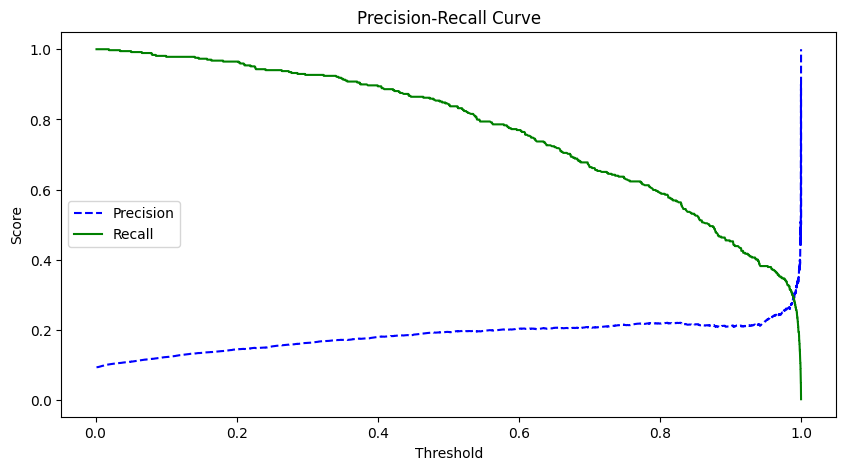

In [152]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(thresholds_pr, precision[:-1], 'b--', label="Precision")
plt.plot(thresholds_pr, recall[:-1], 'g-', label="Recall")
plt.title('Precision-Recall Curve')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

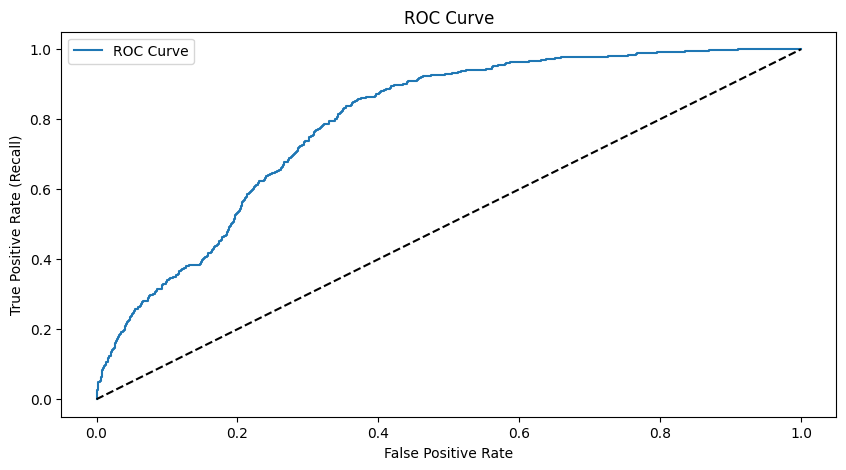

In [153]:
# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

In [154]:
# Find the threshold that gives the best balance between Precision and Recall (e.g., maximizing F1 score)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_threshold_index]

# Output the best threshold
print(f"Best Threshold for balancing Precision and Recall: {best_threshold}")

Best Threshold for balancing Precision and Recall: 0.7723084063505303
